In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
!pip install google-cloud-aiplatform kfp google_cloud_pipeline_components google-cloud-storage --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.1/269.1 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 22.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.12.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.


In [3]:
from google.cloud import aiplatform, storage

In [4]:
!gcloud config set project promptbud

Updated property [core/project].


In [5]:
PROJECT_ID = 'promptbud'
REGION = 'us-east1'
BUCKET_NAME = 'bank-marketing-kfp-sayam'

aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_NAME)

In [6]:
import pandas as pd
data_uri = 'gs://bank-marketing-kfp-sayam/data/bank-full.csv'

df = pd.read_csv(data_uri, sep=';')

In [7]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [7]:
df['y'] = df['y'].map({'no': 0 , 'yes': 1})

In [8]:
df.drop(columns=['duration'], inplace=True)

In [9]:
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
numerical_cols = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']

from sklearn.preprocessing import LabelEncoder
df_rf = df.copy()
label_encoders = {}
for col in categorical_cols:
  lr = LabelEncoder()
  df_rf[col] = lr.fit_transform(df_rf[col])
  label_encoders[col] = lr

In [10]:
df_nn = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [11]:
df_nn = df_nn.astype('float32')
df_nn['y'] = df_nn['y'].astype(int)

In [12]:
df_nn

,age,balance,day,campaign,pdays,previous,y,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,58.0,2143.0,5.0,1.0,-1.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,44.0,29.0,5.0,1.0,-1.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,33.0,2.0,5.0,1.0,-1.0,0.0,0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,47.0,1506.0,5.0,1.0,-1.0,0.0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,33.0,1.0,5.0,1.0,-1.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51.0,825.0,17.0,3.0,-1.0,0.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
45207,71.0,1729.0,17.0,2.0,-1.0,0.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
45208,72.0,5715.0,17.0,5.0,184.0,3.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
45209,57.0,668.0,17.0,4.0,-1.0,0.0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_nn[numerical_cols] = scaler.fit_transform(df_nn[numerical_cols])


In [14]:
from sklearn.model_selection import train_test_split

# Neural Net
X_nn = df_nn.drop('y', axis=1)
y_nn = df_nn['y']
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn, y_nn, test_size=0.2, random_state=42)

# Random Forest
X_rf = df_rf.drop('y', axis=1)
y_rf = df_rf['y']
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)


In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

input_dim = X_train_nn.shape[1]

model = Sequential([
    Dense(16, activation='relu', input_dim= input_dim),
    Dense(8,activation='relu'),
    Dense(1, activation='sigmoid')

])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
model.compile(optimizer='adam', loss='binary_crossentropy',
             metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(
    monitor='val_loss',
    patience = 3
)

history = model.fit(
    X_train_nn, y_train_nn,
    validation_split = 0.2,
    epochs = 20,
    batch_size = 8,
    verbose = 1,
    callbacks = [callback]

)

Epoch 1/20
3617/3617 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8623 - auc: 0.6818 - loss: 0.3630 - val_accuracy: 0.8901 - val_auc: 0.7625 - val_loss: 0.3062
Epoch 2/20
3617/3617 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8938 - auc: 0.7767 - loss: 0.2939 - val_accuracy: 0.8876 - val_auc: 0.7683 - val_loss: 0.3029
Epoch 3/20
3617/3617 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8956 - auc: 0.7946 - loss: 0.2869 - val_accuracy: 0.8889 - val_auc: 0.7768 - val_loss: 0.2993
Epoch 4/20
3617/3617 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8970 - auc: 0.7982 - loss: 0.2837 - val_accuracy: 0.8893 - val_auc: 0.7766 - val_loss: 0.2987
Epoch 5/20
3617/3617 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.8919 - auc: 0.7968 - loss: 0.2916 - val_accuracy: 0.8895 - val_auc: 0.7772 - val_loss: 0.2982
Epoch 6/20
3617/3617 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.8940 - auc: 0.7932 - loss: 0.2898 - val_accuracy: 0.8889 - val_auc: 0.7789 - val_loss: 0.2976
Epoch 7/20
3617/3617 ━

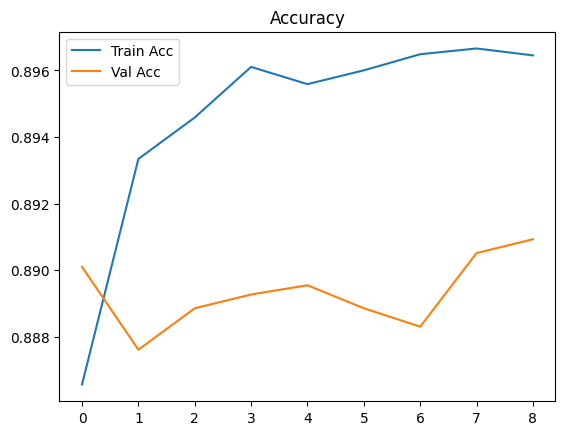

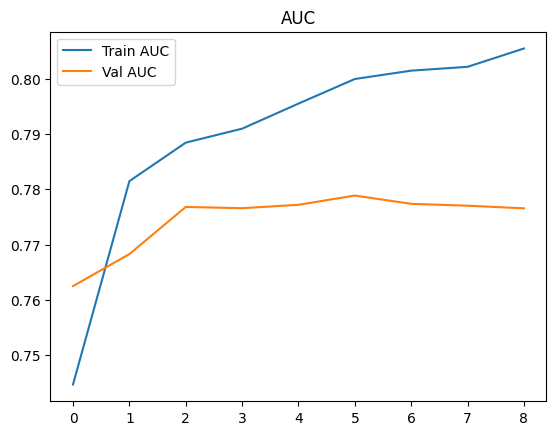

In [34]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

# AUC
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('AUC')
plt.legend()
plt.show()

# Get Raw Data Component

In [87]:
from kfp.v2 import dsl
from kfp.v2.dsl import Artifact, Dataset, component, Output, pipeline, Input, Model

@component(
    packages_to_install=['pandas', 'fsspec', 'gcsfs'],
    base_image= "python:3.10",
    output_component_file= 'getdata.yml'

)
def get_data(
    raw_gcs_url : str,
    raw_dataset : Output[Dataset]
) -> None:

  import pandas as pd

  df = pd.read_csv(raw_gcs_url, sep=';')
  df['y'] = df['y'].map({'no': 0 , 'yes': 1})


  df.to_csv(raw_dataset.path + '.csv', index=False)
  print('Raw_Dataset_Saved at:',raw_dataset.path + '.csv')


<ipython-input-87-e172986f883e>:4: DeprecationWarning: output_component_file parameter is deprecated and will eventually be removed. Please use `Compiler().compile()` to compile a component instead.
  @component(


# Random Forest Prepare Data Component

In [88]:
from kfp.v2 import dsl
from kfp.v2.dsl import Artifact, Dataset, component, Output, pipeline, Input, Model

@component(
    packages_to_install=['pandas', 'fsspec', 'gcsfs', 'scikit-learn'],
    base_image= "python:3.10"
    # output_component_file= 'components/prepare_data_for_rf/prepare_data_for_rf.yml'
)

def prepare_data_for_rf(
    raw_dataset : Input[Dataset],
    train_rf : Output[Dataset],
    test_rf : Output[Dataset],
    label_encoder_obj : Output[Artifact]

)-> None:

  import pandas as pd
  from sklearn.preprocessing import LabelEncoder
  from sklearn.model_selection import train_test_split
  import pickle

  df = pd.read_csv(raw_dataset.path + '.csv')

  if 'duration' in df.columns:
    df.drop(columns=['duration'], inplace=True)


  categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

  label_encoders = {}
  for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


  train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

  train_df.to_csv(train_rf.path + '.csv', index=False)
  test_df.to_csv(test_rf.path + '.csv', index=False)

  with open(label_encoder_obj.path + '.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)


  print('Random Forest Data is Ready')
  print('Label Encoder artifact saved at:', label_encoder_obj.path + '.pkl')

<ipython-input-88-380c5f6a4880>:1: DeprecationWarning: output_component_file parameter is deprecated and will eventually be removed. Please use `Compiler().compile()` to compile a component instead.
  @component(


# Neural Network Prepare Data Component

In [89]:
@component(
    packages_to_install=['pandas', 'fsspec', 'gcsfs', 'scikit-learn'],
    base_image= "python:3.10",
    output_component_file= 'prepare_data_for_nn.yml'
)

def prepare_data_for_nf(
    raw_dataset : Input[Dataset],
    train_nn : Output[Dataset],
    test_nn : Output[Dataset],
    scaler_obj : Output[Artifact]

)-> None:

  import pandas as pd
  from sklearn.preprocessing import StandardScaler
  from sklearn.model_selection import train_test_split
  import pickle

  df = pd.read_csv(raw_dataset.path + '.csv')

  if "duration" in df.columns:
      df.drop(columns=["duration"], inplace=True)

  categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan','contact', 'month', 'poutcome']
  numerical_cols = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']

  df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
  df = df.astype('float32')
  df['y'] = df['y'].astype(int)


  scaler = StandardScaler()
  df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

  train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

  train_df.to_csv(train_nn.path + '.csv', index=False)
  test_df.to_csv(test_nn.path + '.csv', index=False)

  with open(scaler_obj.path + '.pkl', 'wb') as f:
    pickle.dump(scaler, f)

  print('NN data ready')
  print('Scaler obj saved at:', scaler_obj.path + '.pkl')




<ipython-input-89-22fbbe55efc7>:1: DeprecationWarning: output_component_file parameter is deprecated and will eventually be removed. Please use `Compiler().compile()` to compile a component instead.
  @component(


# Train RF-model Component

In [90]:
from kfp.v2 import dsl
from kfp.v2.dsl import Artifact, Dataset, component, Output, pipeline, Input, Model

@component(
    packages_to_install=['pandas', 'fsspec', 'gcsfs', 'scikit-learn', 'joblib'],
    base_image= "python:3.10"
    # output_component_file='train_rf_model.yml'
)
def train_rf_model(
    train_rf : Input[Dataset],
    model_rf : Output[Model]
) -> None:
    import pandas as pd
    from sklearn.ensemble import RandomForestClassifier
    import joblib
    import os
    import pickle
    import pickletools

    train_df = pd.read_csv(train_rf.path + '.csv')
    X_train = train_df.drop('y', axis=1)
    y_train = train_df['y']

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    os.makedirs(model_rf.path, exist_ok=True)
    path = os.path.join(model_rf.path, 'model.pkl')

    with open(path, 'wb') as f:
        pickle.dump(model, f, protocol=4)

    with open(path, 'rb') as f:
        header = f.read(2)
        print("✅ Pickle header:", header)

    print("✅ Model saved at:", path)

<ipython-input-90-6f311d27d5b3>:1: DeprecationWarning: output_component_file parameter is deprecated and will eventually be removed. Please use `Compiler().compile()` to compile a component instead.
  @component(


# Train NN Component

In [91]:
@component(
    packages_to_install=['pandas', 'fsspec', 'gcsfs', 'scikit-learn', 'tensorflow'],
    base_image= "python:3.10",
    output_component_file='train_nn_model.yml'

)
def train_nn_model(
    train_nn : Input[Dataset],
    model_nn : Output[Model]

)->None:

  import pandas as pd
  import tensorflow as tf
  from sklearn.model_selection import train_test_split
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Dense
  from tensorflow.keras.callbacks import EarlyStopping

  import os

  train_df = pd.read_csv(train_nn.path + '.csv')
  X_train = train_df.drop('y', axis=1)
  y_train = train_df['y']


  input_dim = X_train.shape[1]

  model = Sequential([
      Dense(16, activation='relu', input_dim=input_dim),
      Dense(8, activation='relu'),
      Dense(1, activation='sigmoid')

  ])

  model.compile(optimizer='adam', loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])


  callback = EarlyStopping(
      monitor = 'val_loss',
      patience = 2
  )

  history = model.fit(
      X_train, y_train,
      validation_split = 0.2,
      epochs=20,
      batch_size = 8,
      verbose=1,
      callbacks = [callback]
  )

  os.makedirs(model_nn.path, exist_ok=True)
  model.export(model_nn.path)

  # model.save(model_nn.path)



  print('NN saved succesfuly')

<ipython-input-91-6e80aa86ee58>:1: DeprecationWarning: output_component_file parameter is deprecated and will eventually be removed. Please use `Compiler().compile()` to compile a component instead.
  @component(


# Evaluate RF-Model

In [92]:
@component(
    packages_to_install=['pandas', 'fsspec', 'gcsfs', 'scikit-learn', 'joblib', 'google-cloud-aiplatform'],
    base_image= "python:3.10",
    output_component_file='Eval_rf_model.yml'

)
def evaluate_rf(
    test_rf : Input[Dataset],
    model_rf : Input[Model],
    metrics_rf : Output[Artifact],
    project_id: str,
    region: str,
    experiment_name: str,
    run_name : str

)->None:

  import pandas as pd
  from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
  import joblib
  import os
  import json
  from google.cloud import aiplatform

  test_df = pd.read_csv(test_rf.path + '.csv')
  X_test = test_df.drop('y', axis = 1)
  y_test = test_df['y']

  model = joblib.load(os.path.join(model_rf.path, 'model.joblib'))
  y_pred = model.predict(X_test)
  y_proba = model.predict_proba(X_test)[:, 1]


  metrics = {
      "accuracy": accuracy_score(y_test, y_pred),
      "precision": precision_score(y_test, y_pred),
      "recall": recall_score(y_test, y_pred),
      "auc": roc_auc_score(y_test, y_proba)
  }

  os.makedirs(metrics_rf.path, exist_ok=True)
  with open(os.path.join(metrics_rf.path, 'metrics_rf.json'), 'w') as f:
      json.dump(metrics, f, indent=4)

  print("Random Forest model evaluation complete.")
  print("Metrics:", metrics)


  aiplatform.init(project=project_id, location=region, experiment=experiment_name)

  with aiplatform.start_run(run=run_name) as run:

      run.log_params({
          'Model_Type': 'RandomForest',
          'Source': 'Kubeflow'
      })

      run.log_metrics(metrics)



<ipython-input-92-7495e2525afb>:1: DeprecationWarning: output_component_file parameter is deprecated and will eventually be removed. Please use `Compiler().compile()` to compile a component instead.
  @component(


# Evaluate NN- Model

In [93]:
@component(
    packages_to_install=['pandas', 'fsspec', 'gcsfs', 'scikit-learn', 'tensorflow', 'google-cloud-aiplatform'],
    base_image= "python:3.10",
    output_component_file='eval_nn_model.yml'

)
def evaluate_nn(
    test_nn : Input[Dataset],
    model_nn : Input[Model],
    metrics_nn : Output[Artifact],
    project_id: str,
    region: str,
    experiment_name: str,
    run_name: str

)->None:

  import pandas as pd
  import tensorflow as tf
  from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
  import os
  import json
  from google.cloud import aiplatform
  from tensorflow.keras import Sequential
  from tensorflow.keras.layers import TFSMLayer

  test_df = pd.read_csv(test_nn.path + '.csv')
  X_test = test_df.drop('y', axis=1)
  y_test = test_df['y']




  X_tensor = tf.convert_to_tensor(X_test.values, dtype=tf.float32)

  model = TFSMLayer(model_nn.path, call_endpoint="serving_default")


  raw_output = model(X_tensor)
  if isinstance(raw_output, dict):
      y_proba = list(raw_output.values())[0].numpy().flatten()
  else:
      y_proba = raw_output.numpy().flatten()


  y_pred = (y_proba > 0.5).astype(int)
  print(" ✅ Precition Done")

  metrics = {
      "accuracy": accuracy_score(y_test, y_pred),
      "precision": precision_score(y_test, y_pred),
      "recall": recall_score(y_test, y_pred),
      "auc": roc_auc_score(y_test, y_proba)
  }


  os.makedirs(metrics_nn.path, exist_ok=True)
  with open(os.path.join(metrics_nn.path, 'metrics_nn.json'), 'w') as f:
      json.dump(metrics, f, indent=4)


  aiplatform.init(project=project_id, location=region, experiment=experiment_name)

  with aiplatform.start_run(run=run_name) as run:

      run.log_params({
          'Model_Type': 'NeuralNetwork',
          'Source': 'Kubeflow'
      })

      run.log_metrics(metrics)



  print("Neural Network model evaluation complete.")
  print("Metrics:", metrics)



<ipython-input-93-3f8a0cd73a15>:1: DeprecationWarning: output_component_file parameter is deprecated and will eventually be removed. Please use `Compiler().compile()` to compile a component instead.
  @component(


# Best- Model Comparision

In [94]:
@component(
    packages_to_install=['fsspec', 'gcsfs'],
    base_image='python:3.10',
    output_component_file='select_best_model.yml'
)
def select_best_model(
    metrics_rf: Input[Artifact],
    metrics_nn: Input[Artifact],
    model_rf: Input[Model],
    model_nn: Input[Model],
    best_model: Output[Artifact],
    should_deploy: Output[Artifact],
    best_model_path: Output[Artifact],
    best_model_framework: Output[Artifact],
    deploy_thresholds: dict = {
        "auc": 0.70,
        "accuracy": 0.70
    },
    primary_metric: str = "auc"
) -> None:
    import os, json

    with open(os.path.join(metrics_rf.path, 'metrics_rf.json')) as f:
        rf_metrics = json.load(f)
    with open(os.path.join(metrics_nn.path, 'metrics_nn.json')) as f:
        nn_metrics = json.load(f)

    best = "rf" if rf_metrics[primary_metric] >= nn_metrics[primary_metric] else "nn"
    best_metrics = rf_metrics if best == "rf" else nn_metrics

    meets_thresholds = all(
        best_metrics.get(metric, 0) >= threshold
        for metric, threshold in deploy_thresholds.items()
    )

    os.makedirs(best_model.path, exist_ok=True)
    with open(os.path.join(best_model.path, 'best_model.txt'), 'w') as f:
        f.write(best)

    os.makedirs(should_deploy.path, exist_ok=True)
    with open(os.path.join(should_deploy.path, 'deploy.txt'), 'w') as f:
        f.write("True" if meets_thresholds else "False")

    os.makedirs(best_model_path.path, exist_ok=True)
    best_path = model_rf.path if best == "rf" else model_nn.path
    with open(os.path.join(best_model_path.path, 'path.txt'), 'w') as f:
        f.write(best_path)

    os.makedirs(best_model_framework.path, exist_ok=True)
    with open(os.path.join(best_model_framework.path, 'framework.txt'), 'w') as f:
        f.write("sklearn" if best == "rf" else "tensorflow")

    print("Best model:", best)
    print("Path:", best_path)
    print("Should deploy:", meets_thresholds)


<ipython-input-94-979e98232fca>:1: DeprecationWarning: output_component_file parameter is deprecated and will eventually be removed. Please use `Compiler().compile()` to compile a component instead.
  @component(


# Model Registration Component

In [95]:
@component(
    packages_to_install=['google-cloud-aiplatform', 'fsspec', 'gcsfs'],
    base_image="python:3.10",
    output_component_file="register_model.yml"
)


def register_model(
    should_deploy: Input[Artifact],
    best_model_path: Input[Artifact],
    best_model_framework: Input[Artifact],
    project_id: str,
    region: str,
    registered_model: Output[Artifact],
    model_display_name: str = "bank-model"


):
  import os
  from google.cloud import aiplatform


  with open(os.path.join(should_deploy.path, 'deploy.txt'), 'r') as f:
    deploy_flag = f.read().strip()



  if deploy_flag.lower() != "true":
      print("Deployment skipped: Model did not meet thresholds.")
      return

  with open(os.path.join(best_model_path.path, "path.txt"), "r") as f:
      model_dir = f.read().strip()

  with open(os.path.join(best_model_framework.path, "framework.txt"), "r") as f:
      framework = f.read().strip()

  print(f"Registering model from path: {model_dir}")
  print(f"Framework: {framework}")



  aiplatform.init(project=project_id, location=region)

  model = aiplatform.Model.upload(
      display_name = model_display_name,
      artifact_uri = model_dir,

      serving_container_image_uri=(
          "us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.1-0:latest"
          if framework == "sklearn" else
          "us-docker.pkg.dev/vertex-ai/prediction/tf-cpu.2-11:latest"
      )
    )


  model.wait()


  os.makedirs(registered_model.path, exist_ok=True)
  with open(os.path.join(registered_model.path, 'model_uri.txt'), 'w') as f:
      f.write(model.resource_name)

  print(f"Model registered: {model.resource_name}")

<ipython-input-95-a582de03230e>:1: DeprecationWarning: output_component_file parameter is deprecated and will eventually be removed. Please use `Compiler().compile()` to compile a component instead.
  @component(


# Model Deployment Component

In [96]:
from kfp.v2.dsl import component, Input, Output, Artifact

@component(
    packages_to_install=['google-cloud-aiplatform'],
    base_image="python:3.10",
    output_component_file="deploy_model.yaml"
)
def deploy_model(
    registered_model: Input[Artifact],
    project_id: str,
    region: str,
    endpoint_uri: Output[Artifact],
    endpoint_display_name: str = "bank-model-endpoint",
    deployed_model_display_name: str = "bank-model-deployed",
    machine_type: str = "n1-standard-4"

):
    import os
    from google.cloud import aiplatform

    model_uri_file = os.path.join(registered_model.path, 'model_uri.txt')
    with open(model_uri_file, 'r') as f:
        model_resource_name = f.read().strip()


    aiplatform.init(project=project_id, location=region)


    model = aiplatform.Model(model_resource_name)


    endpoints = aiplatform.Endpoint.list(filter=f'display_name="{endpoint_display_name}"', order_by='create_time desc')
    if endpoints:
        endpoint = endpoints[0]
        print(f"Using existing endpoint: {endpoint.name}")
    else:
        endpoint = aiplatform.Endpoint.create(display_name=endpoint_display_name)
        print(f"Created new endpoint: {endpoint.name}")


    model.deploy(
        endpoint=endpoint,
        deployed_model_display_name=deployed_model_display_name,
        machine_type=machine_type,
        traffic_split={"0": 100}
    )


    os.makedirs(endpoint_uri.path, exist_ok=True)
    endpoint_uri_file = os.path.join(endpoint_uri.path, 'endpoint_uri.txt')
    with open(endpoint_uri_file, 'w') as f:
        f.write(endpoint.resource_name)

    print(f"Model deployed to endpoint: {endpoint.resource_name}")


<ipython-input-96-ade317577ab4>:3: DeprecationWarning: output_component_file parameter is deprecated and will eventually be removed. Please use `Compiler().compile()` to compile a component instead.
  @component(


# Pipeline Component

In [97]:
@pipeline(
    name = 'bank-policy-produ',
    pipeline_root = f'gs://{BUCKET_NAME}/pipeline-artifacts'
)

def pipeline():
  get_data_task = get_data(raw_gcs_url=f'gs://{BUCKET_NAME}/data/bank-full.csv')

  prepare_rf_task = prepare_data_for_rf(
      raw_dataset = get_data_task.outputs['raw_dataset']
  )


  prepare_nf_task = prepare_data_for_nf(
      raw_dataset = get_data_task.outputs['raw_dataset']
  )


  train_rf_model_task = train_rf_model(
      train_rf = prepare_rf_task.outputs['train_rf']
  )


  train_nn_model_task = train_nn_model(
      train_nn = prepare_nf_task.outputs['train_nn']
  )


  eval_rf_task = evaluate_rf(
      test_rf = prepare_rf_task.outputs['test_rf'],
      model_rf = train_rf_model_task.outputs['model_rf'],
      project_id=PROJECT_ID,
      region=REGION,
      experiment_name="exprandomforest5prod1",
      run_name = "randomeforestrun5prod1"
  )


  eval_nn_task = evaluate_nn(
      test_nn = prepare_nf_task.outputs['test_nn'],
      model_nn = train_nn_model_task.outputs['model_nn'],
      project_id=PROJECT_ID,
      region=REGION,
      experiment_name="expneuralnetwork5prod1",
      run_name = "neuralnetworrun5prod1"
  )

  best_model_selection_task = select_best_model(
    metrics_rf =  eval_rf_task.outputs['metrics_rf'],
    metrics_nn = eval_nn_task.outputs['metrics_nn'],
    model_rf=train_rf_model_task.outputs['model_rf'],
    model_nn=train_nn_model_task.outputs['model_nn']
  )

  register_model_task = register_model(
      should_deploy = best_model_selection_task.outputs['should_deploy'],
      best_model_path = best_model_selection_task.outputs['best_model_path'],
      best_model_framework = best_model_selection_task.outputs['best_model_framework'],
      project_id = PROJECT_ID,
      region = REGION
  )


  deploy_model_task = deploy_model(
      registered_model=register_model_task.outputs['registered_model'],
      project_id=PROJECT_ID,
      region=REGION,
      endpoint_display_name="bank-model-endpoint",
      deployed_model_display_name="bank-model-deployed",
      machine_type="n1-standard-4"
  )

In [98]:
from kfp.v2 import compiler

compiler.Compiler().compile(
    pipeline_func=pipeline,
    package_path='bank_pipeline.json'
)

In [99]:
from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_NAME)

job = aiplatform.PipelineJob(
    display_name='',
    template_path='bank_pipeline.json',
    pipeline_root = f'gs://{BUCKET_NAME}/pipeline-artifacts'
)
job.run()